<a href="https://colab.research.google.com/github/sayid-alt/sentiment-analysis-nlp/blob/main/Sentiment_analyst_prediction_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: [kaggle](https://www.kaggle.com/datasets/damirolejar/sentiment-analysis-nlp-trainset-data?select=final_negative.txt)

See copied project on [github](https://github.com/sayid-alt/sentiment-analysis-nlp)

# Import library

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding, Flatten, Dropout
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from google.colab import files
from sklearn.metrics import ConfusionMatrixDisplay

import os
import zipfile
import urllib.request

# Utilities

In [2]:
DOWNLOAD_URL = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/data/text.zip'
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'datasets')

def download_data(url=DOWNLOAD_URL, dir=DOWNLOAD_DIR):
    # Downloading data
    print('Downloading data...')
    if not os.path.exists(dir):
        os.makedirs(dir)

    zip_path = os.path.join(dir, 'text.zip')
    urllib.request.urlretrieve(url, zip_path)
    print(f'Success downloading data to {zip_path}')

    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'Success extracting data to {dir}')


# prep data from text file to variable in list type
def prep_data_txt(filepath):
  '''
    filepath: path for text file
    return: list of text
  '''
  datalist = []
  with open(filepath, 'r') as file:
    lines = file.readlines()
    for line in lines:
      datalist.append(line.strip())
  return datalist


# retrieve data
def retrieve_sentiment_data():
  '''
    return: neg_text, pos_text, ne_text as the dataset for sentiment analysis
  '''
  neg_text = prep_data_txt(os.path.join(data_dir, 'final_negative.txt')) #negative data
  pos_text = prep_data_txt(os.path.join(data_dir, 'final_positive.txt'))# positif data
  ne_text = prep_data_txt(os.path.join(data_dir, 'final_neutral.txt'))

  print(f'Negative data length: {len(neg_text)}')
  print(f'Positive data length: {len(pos_text)}')
  print(f'neutral data length: {len(ne_text)}')

  print(f'Negative data sample: {neg_text[:5]}')
  print(f'Positive data sample: {pos_text[:5]}')
  print(f'neutral data sample: {ne_text[:5]}')

  return neg_text, pos_text, ne_text


def stratified_split(df):
  # split data using stratified with size train/val/test 80/10/10 respectively
  df_train, df_test = train_test_split(df,
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=df['label'])


  # split throug test size for get validation split
  df_val, df_test = train_test_split(df_test,
                                     test_size=0.5,
                                     random_state=42,
                                     stratify=df_test['label'])

  value_count = df['label'].value_counts()
  train_count = df_train['label'].value_counts()
  val_count = df_val['label'].value_counts()
  test_count = df_test['label'].value_counts()

  print(f'Value count:\n{value_count}')
  print(f'-----------\nTrain count:\n{train_count}')
  print(f'Val count:\n{val_count}')
  print(f'Test count:\n{test_count}')

  return df_train, df_val, df_test

def check_distribution(labels,
                       title=None,
                       xlabel='Labels',
                       ylabel='Frequency'
                       ):
  plt.figure(figsize=(5, 4))
  sns.histplot(labels, bins=3, color='skyblue')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

def check_split_distribution(labels):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

  for i, label in enumerate(labels):
    label.hist(ax=ax[i], bins=3, color='skyblue')
    ax[i].set_xlabel('Labels')
    ax[i].set_ylabel('Frequency')
  plt.show()



# Download data

In [3]:
download_data()

Success downloading data to /content/datasets/text.zip
Success extracting data to /content/datasets


# Generate Data

In [4]:
data_dir = os.path.join(DOWNLOAD_DIR, 'text')
print(os.listdir(data_dir))

['final_positive.txt', 'final_negative.txt', 'final_neutral.txt']


In [5]:
neg_text, pos_text, ne_text = retrieve_sentiment_data()

Negative data length: 99999
Positive data length: 100000
neutral data length: 99999
Negative data sample: ['Mothers will not give their sons as sacrifices upon the battlefield after twenty years of anxiety and loving devotion in rearing them from infancy, no matter what cause they are called upon to defend.', 'That which was meant to be conducive to life has become the cause of death; that which should have been an evidence of knowledge is now a proof of ignorance; that which was a factor in the sublimity of human nature has proved to be its degradation.', 'The Jews were expecting the appearance of the Messiah, looking forward to it with devotion of heart and soul, but because they were submerged in imitations, they did not believe in Jesus Christ when He appeared.', 'We have forsaken the path of God; we have given up attention to the divine Kingdom; we have not severed the heart from worldly attractions; we have become defiled with qualities which are not praiseworthy in the sight of 

# Data Preprocessing

## Distribution

Below we merge all data into 3 sentiment categories:
- 0: Negative sentiment
- 1: Positif sentiment
- 2: neutral sentimen

In [6]:
df = pd.DataFrame({
    'sentiment' : neg_text + pos_text + ne_text,
    'label' : ['negative'] * len(neg_text) + ['positive'] * len(pos_text) + ['neutral'] * len(ne_text)
})
df.head()

,sentiment,label
0,Mothers will not give their sons as sacrifices...,negative
1,That which was meant to be conducive to life h...,negative
2,The Jews were expecting the appearance of the ...,negative
3,We have forsaken the path of God; we have give...,negative
4,"Sixth, the Messiah was to gather together all ...",negative


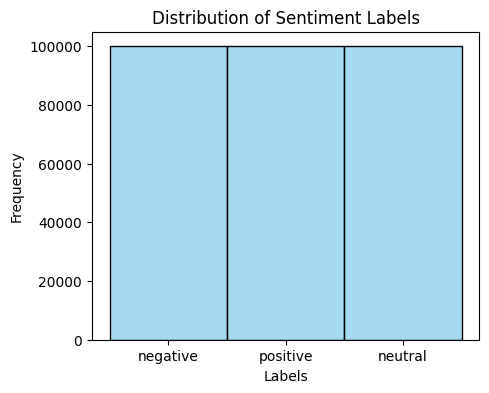

In [7]:
check_distribution(df['label'], 'Distribution of Sentiment Labels')

## Split data

Split data, using stratified shuffle split from sklearn []:
- Train: 80
- Val: 10
- test: 10

In [8]:
# split data using stratified with size train/val/test 80/10/10 respectively
df_train, df_val, df_test = stratified_split(df)

Value count:
label
positive    100000
negative     99999
neutral      99999
Name: count, dtype: int64
-----------
Train count:
label
positive    80000
neutral     79999
negative    79999
Name: count, dtype: int64
Val count:
label
positive    10000
negative    10000
neutral     10000
Name: count, dtype: int64
Test count:
label
negative    10000
neutral     10000
positive    10000
Name: count, dtype: int64


In [9]:
df_train.head(), df_val.head(), df_test.head()

(                                                sentiment     label
 232194  Look at Michael Angelo; poet, painter, sculpto...   neutral
 143208  The story of how Charlemagne dealt with these ...  positive
 124048  It lies in a pleasant undulating district near...  positive
 92224   But the painted foliage on these crags!-the Gr...  negative
 167924  The labor devolving upon him as the commander ...  positive,
                                                 sentiment     label
 160313  In the first volume of the series, entitled Th...  positive
 8888    How jolly it will be, for all but the bad ange...  negative
 219510  154), that the grand conception of a Supreme U...   neutral
 185958  Of course, we hope that you will support the P...  positive
 157285  Lahoma seated herself eagerly and looking up i...  positive,
                                                 sentiment     label
 98454   Just as I had finished our hut, it occurred to...  negative
 47819   No, sir; couldn't move-

## Checking for split distribution

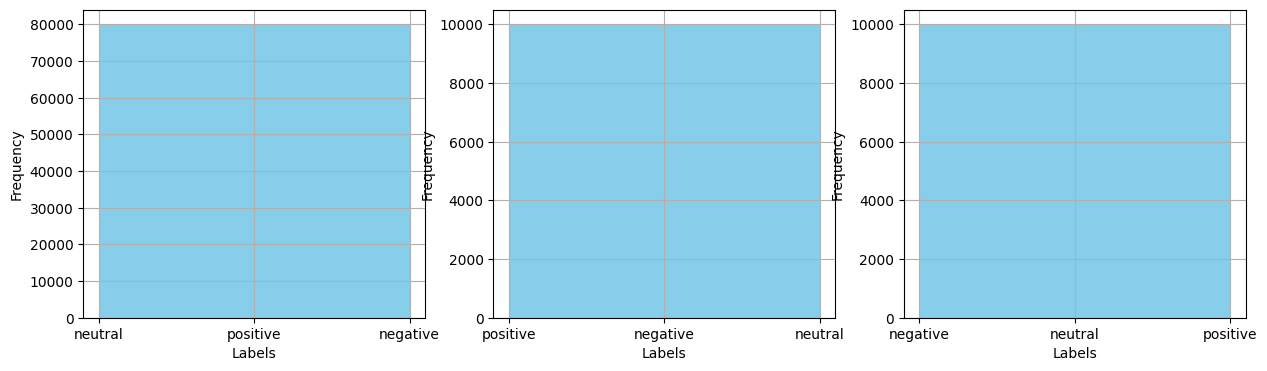

In [10]:

dfs_label = [df_train['label'], df_val['label'], df_test['label']]

check_split_distribution(dfs_label)

In [11]:
# check the size of each split
len_df = len(df)
len_train = len(df_train)
len_val = len(df_val)
len_test = len(df_test)

print(f'Train data size: {round(len_train/len_df,2)}')
print(f'Val data size: {round(len_val/len_df,2)}')
print(f'Test data size: {round(len_test/len_df,2)}')

Train data size: 0.8
Val data size: 0.1
Test data size: 0.1


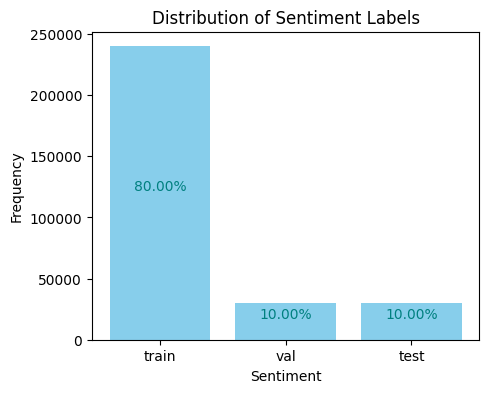

In [12]:
split_name = ['train', 'val', 'test']
split_df = [len_train, len_val, len_test]

plt.figure(figsize=(5, 4))
bars = plt.bar(x=split_name, height=split_df, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height - (height/2.0), '%0.2f%s' % ((height/len_df)*100, '%'), ha='center', va='bottom', color='teal')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Preparation for training

In [13]:
# split for training portion
X_train, y_train = df_train['sentiment'], df_train['label']
X_val, y_val = df_val['sentiment'], df_val['label']
X_test, y_test = df_test['sentiment'], df_test['label']

In [14]:
# X_train.to_csv('X_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# X_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)


In [15]:
# try:
#   from google.colab import files
# except e:
#   print(e)
# else:
#   files.download('X_train.csv')
#   files.download('y_train.csv')
#   files.download('X_val.csv')
#   files.download('y_val.csv')
#   files.download('X_test.csv')
#   files.download('y_test.csv')

### Hyperparameters

In [16]:
# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 50

# Output dimensions of the Embedding layer
embedding_dim = 16

### Tokenize data

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [18]:
print(len(word_index))

122232


In [19]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index_word = label_tokenizer.index_word

# start encoder label from 0
labels_encoder = {key - 1: value for key, value in label_index_word.items()}

# Tokenize the label
training_labels = label_tokenizer.texts_to_sequences(y_train)
val_labels = label_tokenizer.texts_to_sequences(y_val)
test_labels = label_tokenizer.texts_to_sequences(y_test)

In [20]:
print(labels_encoder)
np.unique(y_test)

{0: 'positive', 1: 'neutral', 2: 'negative'}


array(['negative', 'neutral', 'positive'], dtype=object)

In [21]:
# convert labels list to np array
# Below arrays are subtracted by one, because all index should start from 0, instead the current label before subtract started with one
training_labels = np.array(training_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

In [22]:
print(f'label training shape\t : {training_labels.shape}')
print(f'label val shape\t\t : {val_labels.shape}')
print(f'label test shape\t : {test_labels.shape}')

label training shape	 : (239998, 1)
label val shape		 : (30000, 1)
label test shape	 : (30000, 1)


### Sequence data

In [23]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

### padded data

In [24]:
padded_train = pad_sequences(sequences_train, maxlen=max_length, truncating='post', padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post', padding='post')
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post', padding='post')

In [25]:
print(padded_train[0], padded_train.shape)
print(padded_val.shape)
print(padded_test.shape)

[ 237   23 1462 2947 1955 4062 9433 7659    4  990    4   45  310   43
   40   24  265    3 9155  184    1   28 7905  184  899   59   74 5503
   61   14  118    1 1874  140  194   25 6497 1353    4    2 3330 4572
   34 3857    5  559    7    2 8562    2] (239998, 50)
(30000, 50)
(30000, 50)


# Build and compile Model

In [43]:
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

# Set Callbacks

In [45]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=5, restore_best_weights=True)



# Model checkpoint, saving the best only val_acc

checkpoint_filepath = '/tmp/ckpt/checkpoint-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)

csv_logger = CSVLogger('training.log')

# START TRAINING HERE, BE CAREFUL TO RUN CELL BELOW

# Model training

In [46]:
num_epochs=30
history = model.fit(padded_train, training_labels, epochs=num_epochs,
                    validation_data=(padded_val, val_labels), verbose=2,
                    callbacks=[early_stopping, model_checkpoint_callback, csv_logger]
                    )

Epoch 1/30

Epoch 1: saving model to /tmp/ckpt/checkpoint-01-0.727-0.782.keras
7500/7500 - 17s - 2ms/step - accuracy: 0.7267 - loss: 0.6356 - val_accuracy: 0.7819 - val_loss: 0.5162
Epoch 2/30

Epoch 2: saving model to /tmp/ckpt/checkpoint-02-0.795-0.788.keras
7500/7500 - 12s - 2ms/step - accuracy: 0.7955 - loss: 0.5097 - val_accuracy: 0.7876 - val_loss: 0.4990
Epoch 3/30

Epoch 3: saving model to /tmp/ckpt/checkpoint-03-0.803-0.788.keras
7500/7500 - 12s - 2ms/step - accuracy: 0.8035 - loss: 0.4914 - val_accuracy: 0.7884 - val_loss: 0.4987
Epoch 4/30

Epoch 4: saving model to /tmp/ckpt/checkpoint-04-0.807-0.787.keras
7500/7500 - 13s - 2ms/step - accuracy: 0.8068 - loss: 0.4792 - val_accuracy: 0.7867 - val_loss: 0.5008
Epoch 5/30

Epoch 5: saving model to /tmp/ckpt/checkpoint-05-0.810-0.784.keras
7500/7500 - 21s - 3ms/step - accuracy: 0.8095 - loss: 0.4700 - val_accuracy: 0.7840 - val_loss: 0.5115
Epoch 6/30

Epoch 6: saving model to /tmp/ckpt/checkpoint-06-0.812-0.787.keras
7500/7500 -

# Visualize the results

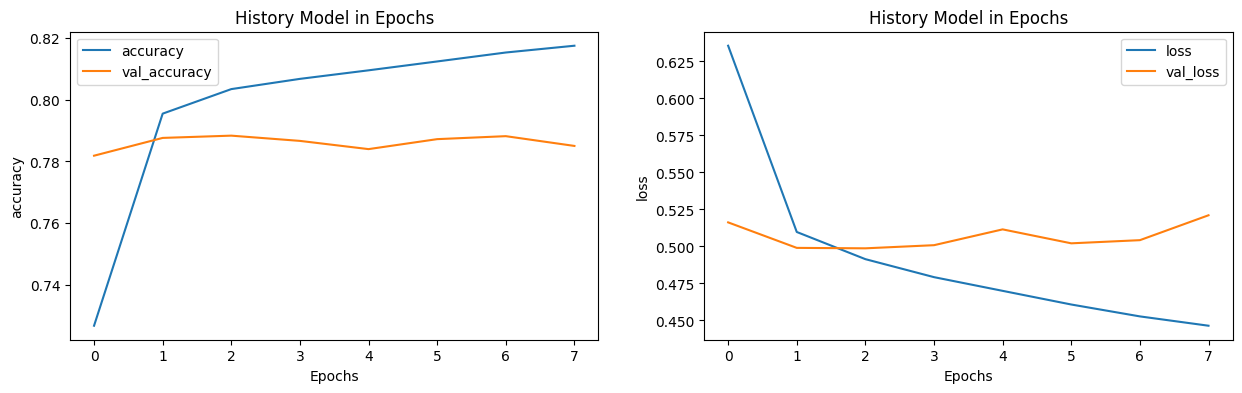

In [47]:
# Plot utility
def plot_graphs(history, strings=['accuracy', 'loss']):
  fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

  for i, string in enumerate(strings):
    ax[i].plot(history.history[string])
    ax[i].plot(history.history['val_'+string])

    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(string)
    ax[i].legend([string, 'val_'+string])
    ax[i].set_title('History Model in Epochs')

  plt.show()

# Plot the accuracy and loss
plot_graphs(history)

# Saving best checkpoint model

In [48]:
!zip -r ckpt.zip /tmp/ckpt
models_to_download = 'ckpt.zip'
try:
  files.download('training.log')
  files.download(models_to_download)

except e:
  print(e)

  adding: tmp/ckpt/ (stored 0%)
  adding: tmp/ckpt/checkpoint-05-0.82-0.79.keras (deflated 7%)
  adding: tmp/ckpt/checkpoint-01-0.69-0.78.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-06-0.81-0.79.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-09-0.79-0.79.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-06-0.812-0.787.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-08-0.79-0.78.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-03-0.81-0.79.keras (deflated 7%)
  adding: tmp/ckpt/checkpoint-07-0.815-0.788.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-08-0.83-0.79.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-08-0.818-0.785.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-07-0.81-0.79.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-10-0.79-0.78.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-04-0.80-0.79.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-05-0.810-0.784.keras (deflated 8%)
  adding: tmp/ckpt/checkpoint-02-0.795-0.788.keras (deflated 8%)
  adding: tmp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# END TRAINING HERE, BE CAREFUL TO RUN CELLS ABOVE

# Evaluate the model

In [170]:
def download_model():
  model_url = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/model/checkpoint-11-0.95-0.94.keras'
  # Find the position of the last forward slash '/'
  last_slash_index = model_url.rfind('/')

  # Extract the substring from the last slash to the end of the string
  model_name = model_url[last_slash_index + 1:]
  urllib.request.urlretrieve(model_url, model_name)
  print('Downloading model...')
  print('Success downloading model')
  return model_name

model_name = download_model()

Success downloading model


In [171]:
# loaded trained model
loaded_model = tf.keras.models.load_model(model_name)

In [172]:
loss, accuracy = loaded_model.evaluate(padded_test, test_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 800, but received input with shape (None, 880)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 55), dtype=int32)
  • training=False
  • mask=None

## Prediction

In [ ]:
# predict the test labels from dataset

# show prediction softmax probability
prediction = loaded_model.predict(padded_test)
print(prediction)

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[[2.91476487e-09 2.09985837e-01 7.90014148e-01]
 [9.99915242e-01 8.41393339e-05 5.47544175e-07]
 [9.86755311e-01 1.09814275e-02 2.26329127e-03]
 ...
 [8.57707061e-09 9.98457789e-01 1.54215214e-03]
 [1.08124430e-11 1.06182830e-04 9.99893785e-01]
 [4.99898009e-02 3.54883447e-02 9.14521873e-01]]


## Confussion Matrix

In [ ]:
labels_encoder

{0: 'negative', 1: 'positive', 2: 'neutral'}

In [ ]:
np.unique(test_labels)

array([0, 1, 2])

In [ ]:
# Return the highest softmax prob index
pred_labels = np.argmax(prediction, axis=1)
print(pred_labels)
con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=pred_labels).numpy()
con_mat

[2 0 0 ... 1 2 2]


array([[2570, 3798, 3483],
       [4026, 3425, 2577],
       [2733, 4461, 2927]], dtype=int32)

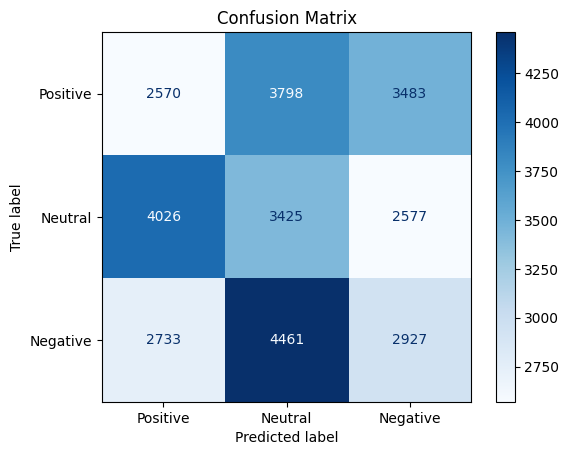

In [ ]:
con_mat_disp = ConfusionMatrixDisplay(con_mat, display_labels=['Positive','Neutral', 'Negative'])
con_mat_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Input user

In [ ]:
user_input = input('Enter a sentence: ')

# tokenize the sentence
user_sequence = tokenizer.texts_to_sequences([user_input])

# pad the sequence
user_padded = pad_sequences(user_sequence, maxlen=max_length, truncating='post', padding='post')

# predict the sentiment
prediction = loaded_model.predict(user_padded)

# -- - Summary prediciton ---
print('---- Prediction summary -----')
print(labels_encoder)
print('Softmax probability:', prediction)

# return the highest probability of 3 categories
predicted_index = np.argmax(prediction, axis=1)

# get the predicted label based on highest probability
predicted_label = labels_encoder[predicted_index[0]]
print(f'Predicted sentiment: {predicted_label}')

Enter a sentence: Despite the promising start, the event turned out to be a complete disaster. The organizers were clearly unprepared, leading to long delays and chaotic arrangements. The speakers were underwhelming, offering nothing new or insightful, and the venue was cramped and uncomfortable. Overall, it was a huge waste of time and money. I left feeling extremely disappointed and frustrated.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
---- Prediction summary -----
{0: 'positive', 1: 'neutral', 2: 'negative'}
Softmax probability: [[9.4049463e-11 1.7162871e-07 9.9999988e-01]]
Predicted sentiment: negative


# Deployment

## Using Pickle

In [ ]:
with open('model.pkl', 'wb') as file:
  pickle.dump(loaded_model, file)

In [ ]:
files.download('model.pkl')